In [ ]:
#default_exp transform

In [ ]:
#export
from fastcore.imports import *
from fastcore.foundation import *
from fastcore.utils import *
from fastcore.dispatch import *
import inspect

In [ ]:
from nbdev.showdoc import *
from fastcore.test import *
from fastcore.nb_imports import *

# Transforms

> Definition of `Transform` and `Pipeline`

The classes here provide functionality for creating a composition of *partially reversible functions*. By "partially reversible" we mean that a transform can be `decode`d, creating a form suitable for display. This is not necessarily identical to the original form (e.g. a transform that changes a byte tensor to a float tensor does not recreate a byte tensor when decoded, since that may lose precision, and a float tensor can be displayed already).

Classes are also provided and for composing transforms, and mapping them over collections. `Pipeline` is a transform which composes several `Transform`, knowing how to decode them or show an encoded item.

## Transform -

In [ ]:
#export
_tfm_methods = 'encodes','decodes','setups'

class _TfmDict(dict):
    def __setitem__(self,k,v):
        if k not in _tfm_methods or not callable(v): return super().__setitem__(k,v)
        if k not in self: super().__setitem__(k,TypeDispatch())
        self[k].add(v)

In [ ]:
#export
class _TfmMeta(type):
    def __new__(cls, name, bases, dict):
        res = super().__new__(cls, name, bases, dict)
        for nm in _tfm_methods:
            base_td = [getattr(b,nm,None) for b in bases]
            if nm in res.__dict__: getattr(res,nm).bases = base_td
            else: setattr(res, nm, TypeDispatch(bases=base_td))
        res.__signature__ = inspect.signature(res.__init__)
        return res

    def __call__(cls, *args, **kwargs):
        f = args[0] if args else None
        n = getattr(f,'__name__',None)
        if callable(f) and n in _tfm_methods:
            getattr(cls,n).add(f)
            return f
        return super().__call__(*args, **kwargs)

    @classmethod
    def __prepare__(cls, name, bases): return _TfmDict()

In [ ]:
#export
def _get_name(o):
    if hasattr(o,'__qualname__'): return o.__qualname__
    if hasattr(o,'__name__'): return o.__name__
    return o.__class__.__name__

In [ ]:
#export
def _is_tuple(o): return isinstance(o, tuple) and not hasattr(o, '_fields')

In [ ]:
#export
class Transform(metaclass=_TfmMeta):
    "Delegates (`__call__`,`decode`,`setup`) to (<code>encodes</code>,<code>decodes</code>,<code>setups</code>) if `split_idx` matches"
    split_idx,init_enc,order,train_setup = None,None,0,None
    def __init__(self, enc=None, dec=None, split_idx=None, order=None):
        self.split_idx = ifnone(split_idx, self.split_idx)
        if order is not None: self.order=order
        self.init_enc = enc or dec
        if not self.init_enc: return

        self.encodes,self.decodes,self.setups = TypeDispatch(),TypeDispatch(),TypeDispatch()
        if enc:
            self.encodes.add(enc)
            self.order = getattr(enc,'order',self.order)
            if len(type_hints(enc)) > 0: self.input_types = first(type_hints(enc).values())
            self._name = _get_name(enc)
        if dec: self.decodes.add(dec)

    @property
    def name(self): return getattr(self, '_name', _get_name(self))
    def __call__(self, x, **kwargs): return self._call('encodes', x, **kwargs)
    def decode  (self, x, **kwargs): return self._call('decodes', x, **kwargs)
    def __repr__(self): return f'{self.name}:\nencodes: {self.encodes}decodes: {self.decodes}'

    def setup(self, items=None, train_setup=False):
        train_setup = train_setup if self.train_setup is None else self.train_setup
        return self.setups(getattr(items, 'train', items) if train_setup else items)

    def _call(self, fn, x, split_idx=None, **kwargs):
        if split_idx!=self.split_idx and self.split_idx is not None: return x
        return self._do_call(getattr(self, fn), x, **kwargs)

    def _do_call(self, f, x, **kwargs):
        if not _is_tuple(x):
            if f is None: return x
            ret = f.returns_none(x) if hasattr(f,'returns_none') else None
            return retain_type(f(x, **kwargs), x, ret)
        res = tuple(self._do_call(f, x_, **kwargs) for x_ in x)
        return retain_type(res, x)

add_docs(Transform, decode="Delegate to <code>decodes</code> to undo transform", setup="Delegate to <code>setups</code> to set up transform")

In [ ]:
show_doc(Transform)

<h2 id="Transform" class="doc_header"><code>class</code> <code>Transform</code><a href="" class="source_link" style="float:right">[source]</a></h2>

> <code>Transform</code>(**`enc`**=*`None`*, **`dec`**=*`None`*, **`split_idx`**=*`None`*, **`order`**=*`None`*)

Delegates (`__call__`,`decode`,`setup`) to (<code>encodes</code>,<code>decodes</code>,<code>setups</code>) if `split_idx` matches

A `Transform` is the main building block of the fastai data pipelines. In the most general terms a transform can be any function you want to apply to your data, however the `Transform` class provides several mechanisms that make the process of building them easy and flexible.

### The main `Transform` features:

- **Type dispatch** - Type annotations are used to determine if a transform should be applied to the given argument. It also gives an option to provide several implementations and it choses the one to run based on the type. This is useful for example when running both independent and dependent variables through the pipeline where some transforms only make sense for one and not the other. Another usecase is designing a transform that handles different data formats. Note that if a transform takes multiple arguments only the type of the first one is used for dispatch. 
- **Handling of tuples** - When a tuple (or a subclass of tuple) of data is passed to a transform it will get applied to each element separately. You can opt out of this behavior by passing a list or an `L`, as only tuples gets this specific behavior. An alternative is to use `ItemTransform` defined below, which will always take the input as a whole.
- **Reversability** - A transform can be made reversible by implementing the <code>decodes</code> method. This is mainly used to turn something like a category which is encoded as a number back into a label understandable by humans for showing purposes. Like the regular call method, the `decode` method that is used to decode will be applied over each element of a tuple separately.
- **Type propagation** - Whenever possible a transform tries to return data of the same type it received. Mainly used to maintain semantics of things like `ArrayImage` which is a thin wrapper of pytorch's `Tensor`. You can opt out of this behavior by adding `->None` return type annotation.
- **Preprocessing** - The `setup` method can be used to perform any one-time calculations to be later used by the transform, for example generating a vocabulary to encode categorical data.
- **Filtering based on the dataset type** - By setting the `split_idx` flag you can make the transform be used only in a specific `DataSource` subset like in training, but not validation.
- **Ordering** - You can set the `order` attribute which the `Pipeline` uses when it needs to merge two lists of transforms.
- **Appending new behavior with decorators** - You can easily extend an existing `Transform` by creating <code>encodes</code> or <code>decodes</code> methods for new data types. You can put those new methods outside the original transform definition and decorate them with the class you wish them patched into. This can be used by the fastai library users to add their own behavior, or multiple modules contributing to the same transform.

### Defining a `Transform`

There are a few ways to create a transform with different ratios of simplicity to flexibility.
- **Extending the `Transform` class** - Use inheritence to implement the methods you want.
- **Passing methods to the constructor** - Instantiate the `Transform` class and pass your functions as `enc` and `dec` arguments.
- **@Transform decorator** - Turn any function into a `Transform` by just adding a decorator - very straightforward if all you need is a single <code>encodes</code> implementation.
- **Passing a function to fastai APIs** - Same as above, but when passing a function to other transform aware classes like `Pipeline` or `TfmdDS` you don't even need a decorator. Your function will get converted to a `Transform` automatically.

In [ ]:
class A(Transform): pass
@A
def encodes(self, x): return x+1
f1 = A()
test_eq(f1(1), 2)

class B(A): pass
@B
def decodes(self, x): return x-1
f2 = B()
test_eq(f2(1), 2)
test_eq(f2.decode(2), 1)
test_eq(f1.decode(2), 2)

class A(Transform): pass
f3 = A()
test_eq_type(f3(2), 2)
test_eq_type(f3.decode(2.0), 2.0)

`Transform` can be used as a decorator, to turn a function into a `Transform`.

In [ ]:
f = Transform(lambda o:o//2)

In [ ]:
test_eq_type(f(2), 1)
test_eq_type(f.decode(2.0), 2.0)

In [ ]:
@Transform
def f(x): return x//2
test_eq_type(f(2), 1)
test_eq_type(f.decode(2.0), 2.0)

@Transform
def f(x): return x*2
test_eq_type(f(2), 4)
test_eq_type(f.decode(2.0), 2.0)

You can derive from `Transform` and use <code>encodes</code> for your encoding function.

In [ ]:
class ArrayImage(ndarray):
    _show_args = {'cmap':'viridis'}
    def __new__(cls, x, *args, **kwargs):
        if isinstance(x,tuple): super().__new__(cls, x, *args, **kwargs)
        if args or kwargs: raise RuntimeError('Unknown array init args')
        if not isinstance(x,ndarray): x = array(x)
        return x.view(cls)
    
    def show(self, ctx=None, figsize=None, **kwargs):
        if ctx is None: _,ctx = plt.subplots(figsize=figsize)
        ctx.imshow(im, **{**self._show_args, **kwargs})
        ctx.axis('off')
        return ctx
    
im = Image.open(TEST_IMAGE)
im_t = ArrayImage(im)

In [ ]:
class A(Transform):
    def encodes(self, x:ArrayImage): return -x
    def decodes(self, x:ArrayImage): return x+1
    def setups (self, x:ArrayImage): x.foo = 'a'
f = A()
t = f(im_t)
test_eq(t, -im_t)
test_eq(f(1), 1)
test_eq(type(t), ArrayImage)
test_eq(f.decode(t), -im_t+1)
test_eq(f.decode(1), 1)
f.setup(im_t)
test_eq(im_t.foo, 'a')
t2 = array(1)
f.setup(t2)
assert not hasattr(f2,'foo')
f

A:
encodes: (ArrayImage,object) -> encodes
decodes: (ArrayImage,object) -> decodes

Without return annotation we get an `Int` back since that's what was passed.

In [ ]:
class A(Transform): pass
@A
def encodes(self, x:Int): return x//2
@A
def encodes(self, x:float): return x+1

f = A()
test_eq_type(f(Int(2)), Int(1))
test_eq_type(f(2), 2)
test_eq_type(f(2.), 3.)

Without return annotation we don't cast if we're not a subclass of the input type. If the annotation is a tuple, then any type in the tuple will match.

In [ ]:
class A(Transform):
    def encodes(self, x:(Int,float)): return x/2
    def encodes(self, x:(str,list)): return str(x)+'1'

f = A()
test_eq_type(f(Int(2)), 1.)
test_eq_type(f(2), 2)
test_eq_type(f(Float(2.)), Float(1.))
test_eq_type(f('a'), 'a1')

With return annotation `None` we get back whatever Python creates usually.

In [ ]:
def func(x)->None: return x/2
f = Transform(func)
test_eq_type(f(2), 1.)
test_eq_type(f(2.), 1.)

Since <code>decodes</code> has no return annotation, but <code>encodes</code> created an `Int` and we pass that result here to `decode`, we end up with an `Int`.

In [ ]:
def func(x): return Int(x+1)
def dec (x): return x-1
f = Transform(func,dec)
t = f(1)
test_eq_type(t, Int(2))
test_eq_type(f.decode(t), Int(1))

If the transform has `split_idx` then it's only applied if `split_idx` param matches.

In [ ]:
f.split_idx = 1
test_eq(f(1, split_idx=1),2)
test_eq_type(f(1, split_idx=0), 1)

Transform takes lists as a whole and is applied to them.

In [ ]:
class A(Transform): 
    def encodes(self, xy): x,y=xy; return [x+y,y]
    def decodes(self, xy): x,y=xy; return [x-y,y]

f = A()
t = f([1,2])
test_eq(t, [3,2])
test_eq(f.decode(t), [1,2])
f.split_idx = 1
test_eq(f([1,2], split_idx=1), [3,2])
test_eq(f([1,2], split_idx=0), [1,2])

In [ ]:
class AL(Transform): pass
@AL
def encodes(self, x): return L(x_+1 for x_ in x)
@AL
def decodes(self, x): return L(x_-1 for x_ in x)

f = AL()
t = f([1,2])
test_eq(t, [2,3])
test_eq(f.decode(t), [1,2])

Transforms are applied to each element of a tuple.

In [ ]:
def neg_int(x:numbers.Integral): return -x

f = Transform(neg_int)
test_eq(f((1,)), (-1,))
test_eq(f((1.,)), (1.,))
test_eq(f((1.,2,3.)), (1.,-2,3.))
test_eq(f.decode((1,2)), (1,2))

In [ ]:
#hide
test_eq(f.input_types, numbers.Integral)

In [ ]:
#export
class InplaceTransform(Transform):
    "A `Transform` that modifies in-place and just returns whatever it's passed"
    def _call(self, fn, x, split_idx=None, **kwargs):
        super()._call(fn,x,split_idx,**kwargs)
        return x

In [ ]:
#hide
import pandas as pd

In [ ]:
class A(InplaceTransform): pass
@A
def encodes(self, x:pd.Series): x.fillna(10, inplace=True)
f = A()
test_eq_type(f(pd.Series([1,2,None])),pd.Series([1,2,10]))

In [ ]:
class B(Transform): pass

@B
def encodes(self, x:int): return x+1
@B
def encodes(self, x:str): return x+'1'
@B
def encodes(self, x)->None: return str(x)+'!'

b = B()
test_eq(b([1]), '[1]!')
test_eq(b((1,)), (2,))
test_eq(b(('1',)), ('11',))
test_eq(b([1.0]), '[1.0]!')
test_eq(b.decode([2]), [2])
assert pickle.loads(pickle.dumps(b))

In [ ]:
@B
def decodes(self, x:int): return x-1
test_eq(b.decode((2,)), (1,))
test_eq(b.decode(('2',)), ('2',))

Non-type-constrained functions are applied to all elements of a tuple.

In [ ]:
class A(Transform): pass
@A
def encodes(self, x): return x+1
@A
def decodes(self, x): return x-1

f = A()
t = f((1,2.0))
test_eq_type(t, (2,3.0))
test_eq_type(f.decode(t), (1,2.0))

Type-constrained functions are applied to only matching elements of a tuple, and return annotations are only applied where matching.

In [ ]:
class B(Transform):
    def encodes(self, x:int): return Int(x+1)
    def encodes(self, x:str): return x+'1'
    def decodes(self, x:Int): return x//2

f = B()
start = (1.,2,'3')
t = f(start)
test_eq_type(t, (1.,Int(3),'31'))
test_eq(f.decode(t), (1.,Int(1),'31'))

The dispatching over tuples works recursively, by the way:

In [ ]:
f = B()
start = (1.,(2,'3'))
t = f(start)
test_eq_type(t, (1.,(Int(3),'31')))
test_eq(f.decode(t), (1.,(Int(1),'31')))

The same behavior also works with `typing` module type classes.

In [ ]:
class A(Transform): pass
@A
def encodes(self, x:numbers.Integral): return x+1
@A
def encodes(self, x:float): return x*3
@A
def decodes(self, x:int): return x-1

f = A()
start = 1.0
t = f(start)
test_eq(t, 3.)
test_eq(f.decode(t), 3)

start = (1.,2,3.)
t = f(start)
test_eq(t, (3.,3,9.))
test_eq(f.decode(t), (3.,2,9.))

In [ ]:
# export
class DisplayedTransform(Transform):
    "A transform with a `__repr__` that shows its attrs"

    @property
    def name(self): return f"{super().name} -- {getattr(self,'__stored_args__',{})}"

Transforms normally are represented by just their class name and a list of encodes and decodes implementations:

In [ ]:
class A(Transform): encodes,decodes = noop,noop
f = A()
f

A:
encodes: (object,object) -> noop
decodes: (object,object) -> noop

A `DisplayedTransform` will in addition show the contents of all attributes listed in the comma-delimited string `self.store_attrs`:

In [ ]:
class A(DisplayedTransform):
    encodes = noop
    def __init__(self, a, b=2):
        super().__init__()
        store_attr()
    
A(a=1,b=2)

A -- {'a': 1, 'b': 2}:
encodes: (object,object) -> noop
decodes: 

#### ItemTransform -

In [ ]:
#export
class ItemTransform(Transform):
    "A transform that always take tuples as items"
    _retain = True
    def __call__(self, x, **kwargs): return self._call1(x, '__call__', **kwargs)
    def decode(self, x, **kwargs):   return self._call1(x, 'decode', **kwargs)
    def _call1(self, x, name, **kwargs):
        if not _is_tuple(x): return getattr(super(), name)(x, **kwargs)
        y = getattr(super(), name)(list(x), **kwargs)
        if not self._retain: return y
        if is_listy(y) and not isinstance(y, tuple): y = tuple(y)
        return retain_type(y, x)

`ItemTransform` is the class to use to opt out of the default behavior of `Transform`.

In [ ]:
class AIT(ItemTransform): 
    def encodes(self, xy): x,y=xy; return (x+y,y)
    def decodes(self, xy): x,y=xy; return (x-y,y)
    
f = AIT()
test_eq(f((1,2)), (3,2))
test_eq(f.decode((3,2)), (1,2))

If you pass a special tuple subclass, the usual retain type behavior of `Transform` will keep it:

In [ ]:
class _T(tuple): pass
x = _T((1,2))
test_eq_type(f(x), _T((3,2)))

In [ ]:
#hide
f.split_idx = 0
test_eq_type(f((1,2)), (1,2))
test_eq_type(f((1,2), split_idx=0), (3,2))
test_eq_type(f.decode((1,2)), (1,2))
test_eq_type(f.decode((3,2), split_idx=0), (1,2))

In [ ]:
#hide
class Get(ItemTransform):
    _retain = False
    def encodes(self, x): return x[0]
    
g = Get()
test_eq(g([1,2,3]), 1)
test_eq(g(L(1,2,3)), 1)
test_eq(g(np.array([1,2,3])), 1)
test_eq_type(g((['a'], ['b', 'c'])), ['a'])

In [ ]:
#hide
class A(ItemTransform): 
    def encodes(self, x): return _T((x,x))
    def decodes(self, x): return _T(x)
    
f = A()
test_eq(type(f.decode((1,1))), _T)

### Func -

In [ ]:
#export
def get_func(t, name, *args, **kwargs):
    "Get the `t.name` (potentially partial-ized with `args` and `kwargs`) or `noop` if not defined"
    f = getattr(t, name, noop)
    return f if not (args or kwargs) else partial(f, *args, **kwargs)

This works for any kind of `t` supporting `getattr`, so a class or a module.

In [ ]:
test_eq(get_func(operator, 'neg', 2)(), -2)
test_eq(get_func(operator.neg, '__call__')(2), -2)
test_eq(get_func(list, 'foobar')([2]), [2])
a = [2,1]
get_func(list, 'sort')(a)
test_eq(a, [1,2])

Transforms are built with multiple-dispatch: a given function can have several methods depending on the type of the object received. This is done directly with the `TypeDispatch` module and type-annotation in `Transform`, but you can also use the following class.

In [ ]:
#export
class Func():
    "Basic wrapper around a `name` with `args` and `kwargs` to call on a given type"
    def __init__(self, name, *args, **kwargs): self.name,self.args,self.kwargs = name,args,kwargs
    def __repr__(self): return f'sig: {self.name}({self.args}, {self.kwargs})'
    def _get(self, t): return get_func(t, self.name, *self.args, **self.kwargs)
    def __call__(self,t): return mapped(self._get, t)

You can call the `Func` object on any module name or type, even a list of types. It will return the corresponding function (with a default to `noop` if nothing is found) or list of functions.

In [ ]:
test_eq(Func('sqrt')(math), math.sqrt)

In [ ]:
#export
class _Sig():
    def __getattr__(self,k):
        def _inner(*args, **kwargs): return Func(k, *args, **kwargs)
        return _inner

Sig = _Sig()

In [ ]:
show_doc(Sig, name="Sig")

<h4 id="Sig" class="doc_header"><code>Sig</code><a href="__main__.py#L4" class="source_link" style="float:right">[source]</a></h4>

> <code>Sig</code>(**\*`args`**, **\*\*`kwargs`**)



`Sig` is just sugar-syntax to create a `Func` object more easily with the syntax `Sig.name(*args, **kwargs)`.

In [ ]:
f = Sig.sqrt()
test_eq(f(math), math.sqrt)

## Pipeline -

In [ ]:
#export
def compose_tfms(x, tfms, is_enc=True, reverse=False, **kwargs):
    "Apply all `func_nm` attribute of `tfms` on `x`, maybe in `reverse` order"
    if reverse: tfms = reversed(tfms)
    for f in tfms:
        if not is_enc: f = f.decode
        x = f(x, **kwargs)
    return x

In [ ]:
def to_int  (x):   return Int(x)
def to_float(x):   return Float(x)
def double  (x):   return x*2
def half(x)->None: return x/2

In [ ]:
def test_compose(a, b, *fs): test_eq_type(compose_tfms(a, tfms=map(Transform,fs)), b)

test_compose(1,   Int(1),   to_int)
test_compose(1,   Float(1), to_int,to_float)
test_compose(1,   Float(2), to_int,to_float,double)
test_compose(2.0, 2.0,      to_int,double,half)

In [ ]:
class A(Transform):
    def encodes(self, x:float):  return Float(x+1)
    def decodes(self, x): return x-1
    
tfms = [A(), Transform(math.sqrt)]
t = compose_tfms(3., tfms=tfms)
test_eq_type(t, Float(2.))
test_eq(compose_tfms(t, tfms=tfms, is_enc=False), 1.)
test_eq(compose_tfms(4., tfms=tfms, reverse=True), 3.)

In [ ]:
tfms = [A(), Transform(math.sqrt)]
test_eq(compose_tfms((9,3.), tfms=tfms), (3,2.))

In [ ]:
#export
def mk_transform(f):
    "Convert function `f` to `Transform` if it isn't already one"
    f = instantiate(f)
    return f if isinstance(f,(Transform,Pipeline)) else Transform(f)

In [ ]:
#export
def gather_attrs(o, k, nm):
    "Used in __getattr__ to collect all attrs `k` from `self.{nm}`"
    if k.startswith('_') or k==nm: raise AttributeError(k)
    att = getattr(o,nm)
    res = [t for t in att.attrgot(k) if t is not None]
    if not res: raise AttributeError(k)
    return res[0] if len(res)==1 else L(res)

In [ ]:
#export
def gather_attr_names(o, nm):
    "Used in __dir__ to collect all attrs `k` from `self.{nm}`"
    return L(getattr(o,nm)).map(dir).concat().unique()

In [ ]:
#export
class Pipeline:
    "A pipeline of composed (for encode/decode) transforms, setup with types"
    def __init__(self, funcs=None, split_idx=None):
        self.split_idx,self.default = split_idx,None
        if funcs is None: funcs = []
        if isinstance(funcs, Pipeline): self.fs = funcs.fs
        else:
            if isinstance(funcs, Transform): funcs = [funcs]
            self.fs = L(ifnone(funcs,[noop])).map(mk_transform).sorted(key='order')
        for f in self.fs:
            name = camel2snake(type(f).__name__)
            a = getattr(self,name,None)
            if a is not None: f = L(a)+f
            setattr(self, name, f)

    def setup(self, items=None, train_setup=False):
        tfms = self.fs[:]
        self.fs.clear()
        for t in tfms: self.add(t,items, train_setup)

    def add(self,t, items=None, train_setup=False):
        t.setup(items, train_setup)
        self.fs.append(t)

    def __call__(self, o): return compose_tfms(o, tfms=self.fs, split_idx=self.split_idx)
    def __repr__(self): return f"Pipeline: {' -> '.join([f.name for f in self.fs if f.name != 'noop'])}"
    def __getitem__(self,i): return self.fs[i]
    def __setstate__(self,data): self.__dict__.update(data)
    def __getattr__(self,k): return gather_attrs(self, k, 'fs')
    def __dir__(self): return super().__dir__() + gather_attr_names(self, 'fs')

    def decode  (self, o, full=True):
        if full: return compose_tfms(o, tfms=self.fs, is_enc=False, reverse=True, split_idx=self.split_idx)
        #Not full means we decode up to the point the item knows how to show itself.
        for f in reversed(self.fs):
            if self._is_showable(o): return o
            o = f.decode(o, split_idx=self.split_idx)
        return o

    def show(self, o, ctx=None, **kwargs):
        o = self.decode(o, full=False)
        o1 = (o,) if not _is_tuple(o) else o
        if hasattr(o, 'show'): ctx = o.show(ctx=ctx, **kwargs)
        else:
            for o_ in o1:
                if hasattr(o_, 'show'): ctx = o_.show(ctx=ctx, **kwargs)
        return ctx

    def _is_showable(self, o):
        if hasattr(o, 'show'): return True
        if _is_tuple(o): return all(hasattr(o_, 'show') for o_ in o)
        return False

In [ ]:
add_docs(Pipeline,
         __call__="Compose `__call__` of all `fs` on `o`",
         decode="Compose `decode` of all `fs` on `o`",
         show="Show `o`, a single item from a tuple, decoding as needed",
         add="Add transform `t`",
         setup="Call each tfm's `setup` in order")

`Pipeline` is a wrapper for `compose_tfm`. You can pass instances of `Transform` or regular functions in `funcs`, the `Pipeline` will wrap them all in `Transform` (and instantiate them if needed) during the initialization. It handles the transform `setup` by adding them one at a time and calling setup on each, goes through them in order in `__call__` or `decode` and can `show` an object by applying decoding the transforms up until the point it gets an object that knows how to show itself.

In [ ]:
# Empty pipeline is noop
pipe = Pipeline()
test_eq(pipe(1), 1)
test_eq(pipe((1,)), (1,))
# Check pickle works
assert pickle.loads(pickle.dumps(pipe))

In [ ]:
class IntFloatTfm(Transform):
    def encodes(self, x):  return Int(x)
    def decodes(self, x):  return Float(x)
    foo=1

int_tfm=IntFloatTfm()

def neg(x): return -x
neg_tfm = Transform(neg, neg)

In [ ]:
pipe = Pipeline([neg_tfm, int_tfm])

start = 2.0
t = pipe(start)
test_eq_type(t, Int(-2))
test_eq_type(pipe.decode(t), Float(start))
test_stdout(lambda:pipe.show(t), '-2')

In [ ]:
pipe = Pipeline([neg_tfm, int_tfm])
t = pipe(start)
test_stdout(lambda:pipe.show(pipe((1.,2.))), '-1\n-2')
test_eq(pipe.foo, 1)
assert 'foo' in dir(pipe)
assert 'int_float_tfm' in dir(pipe)

Transforms are available as attributes named with the snake_case version of the names of their types. Attributes in transforms can be directly accessed as attributes of the pipeline.

In [ ]:
test_eq(pipe.int_float_tfm, int_tfm)
test_eq(pipe.foo, 1)

pipe = Pipeline([int_tfm, int_tfm])
pipe.int_float_tfm
test_eq(pipe.int_float_tfm[0], int_tfm)
test_eq(pipe.foo, [1,1])

In [ ]:
# Check opposite order
pipe = Pipeline([int_tfm,neg_tfm])
t = pipe(start)
test_eq(t, -2)
test_stdout(lambda:pipe.show(t), '-2')

In [ ]:
class A(Transform):
    def encodes(self, x):  return int(x)
    def decodes(self, x):  return Float(x)

pipe = Pipeline([neg_tfm, A])
t = pipe(start)
test_eq_type(t, -2)
test_eq_type(pipe.decode(t), Float(start))
test_stdout(lambda:pipe.show(t), '-2.0')

In [ ]:
s2 = (1,2)
pipe = Pipeline([neg_tfm, A])
t = pipe(s2)
test_eq_type(t, (-1,-2))
test_eq_type(pipe.decode(t), (Float(1.),Float(2.)))
test_stdout(lambda:pipe.show(t), '-1.0\n-2.0')

In [ ]:
class B(Transform):
    def encodes(self, x): return x+1
    def decodes(self, x): return x-1

In [ ]:
from PIL import Image

In [ ]:
def f1(x:ArrayImage): return -x
def f2(x): return Image.open(x).resize((128,128))
def f3(x:Image.Image): return(ArrayImage(array(x)))

In [ ]:
pipe = Pipeline([f2,f3,f1])
t = pipe(TEST_IMAGE)
test_eq(type(t), ArrayImage)
test_eq(t, -array(f3(f2(TEST_IMAGE))))

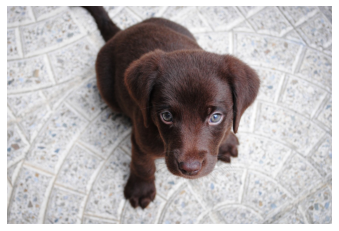

In [ ]:
pipe = Pipeline([f2,f3])
t = pipe(TEST_IMAGE)
ax = pipe.show(t)

In [ ]:
test_fig_exists(ax)

In [ ]:
#Check filtering is properly applied
add1 = B()
add1.split_idx = 1
pipe = Pipeline([neg_tfm, A(), add1])
test_eq(pipe(start), -2)
pipe.split_idx=1
test_eq(pipe(start), -1)
pipe.split_idx=0
test_eq(pipe(start), -2)
for t in [None, 0, 1]:
    pipe.split_idx=t
    test_eq(pipe.decode(pipe(start)), start)
    test_stdout(lambda: pipe.show(pipe(start)), "-2.0")

In [ ]:
def neg(x): return -x
test_eq(type(mk_transform(neg)), Transform)
test_eq(type(mk_transform(math.sqrt)), Transform)
test_eq(type(mk_transform(lambda a:a*2)), Transform)
test_eq(type(mk_transform(Pipeline([neg]))), Pipeline)

### Methods

In [ ]:
#TODO: method examples

In [ ]:
show_doc(Pipeline.__call__)

<h4 id="Pipeline.__call__" class="doc_header"><code>Pipeline.__call__</code><a href="__main__.py#L26" class="source_link" style="float:right">[source]</a></h4>

> <code>Pipeline.__call__</code>(**`o`**)

Compose `__call__` of all `fs` on `o`

In [ ]:
show_doc(Pipeline.decode)

<h4 id="Pipeline.decode" class="doc_header"><code>Pipeline.decode</code><a href="__main__.py#L33" class="source_link" style="float:right">[source]</a></h4>

> <code>Pipeline.decode</code>(**`o`**, **`full`**=*`True`*)

Compose `decode` of all `fs` on `o`

In [ ]:
show_doc(Pipeline.setup)

<h4 id="Pipeline.setup" class="doc_header"><code>Pipeline.setup</code><a href="__main__.py#L17" class="source_link" style="float:right">[source]</a></h4>

> <code>Pipeline.setup</code>(**`items`**=*`None`*, **`train_setup`**=*`False`*)

Call each tfm's `setup` in order

During the setup, the `Pipeline` starts with no transform and adds them one at a time, so that during its setup, each transform gets the items processed up to its point and not after.

In [ ]:
#hide
#Test is with TfmdList

## Export -

In [ ]:
#hide
from nbdev.export import notebook2script
notebook2script()

Converted 00_test.ipynb.
Converted 01_foundation.ipynb.
Converted 02_utils.ipynb.
Converted 03_dispatch.ipynb.
Converted 04_transform.ipynb.
Converted index.ipynb.
